In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from nltk.corpus import stopwords
import numpy as np
import os
from sklearn.metrics import accuracy_score

pd.set_option('display.max_colwidth', None)

plt.rcParams['figure.dpi'] = 500

DATASET = 145

python(74905) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/josh/Desktop/Coding 👨🏽‍💻/sentiment_analysis/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Dataset class
class FinancialSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

In [3]:
# Load the dataset
df = pd.read_feather("../Data/Data145_NoClean.feather")

print(df.info())
print(df.sample(5))
print("\n", df['sentiment'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22417 entries, 0 to 22416
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       22417 non-null  object
 1   sentiment  22417 non-null  int64 
 2   base_url   22417 non-null  object
dtypes: int64(1), object(2)
memory usage: 525.5+ KB
None
                                                                                                                                          text  \
7383                                      TJX Companies Inc $TJX Expected to Announce Quarterly Sales of $9.02 Billion https://t.co/jvlF6UXOpS   
1655                                                Q2 2018 Earnings Estimate for Whirlpool Co. $WHR Issued By KeyCorp https://t.co/Wzis5qSb0i   
1329                                        $0.43 Earnings Per Share Expected for Alliant Energy Co. $LNT This Quarter https://t.co/5QSNxyogbi   
20470  Verge $XVG price: $0.026301 We checked! Binance r

In [4]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
# Add additional stop words for financial context
stop_words_appended = stopwords.words('english')
stop_words_appended.extend(['rt', 'ep'])

In [6]:
# Check for model checkpoint
model_path = f'./Results/{DATASET}/checkpoint-22420'
if os.path.isdir(model_path):
    print("Loading model from checkpoint.")
    model = BertForSequenceClassification.from_pretrained(model_path)
else:
    print("No checkpoint found. Initializing from base model.")
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Loading model from checkpoint.


In [7]:
# Split the dataset
X = df[['text', 'base_url']].apply(lambda x: ' '.join(x), axis=1)
Y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
train_dataset = FinancialSentimentDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = FinancialSentimentDataset(X_test.tolist(), y_test.tolist(), tokenizer)

In [9]:
# Training arguments
training_args = TrainingArguments(
    output_dir=f'./Results/{DATASET}',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f'./Logs/{DATASET}',
    logging_steps=5,
    load_best_model_at_end=True,
    save_strategy="epoch",
    evaluation_strategy="epoch"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

if not os.path.exists(model_path):
    print("Starting training...")
    trainer.train()
else:
    print("Skipping training...")

/Users/josh/Desktop/Coding 👨🏽‍💻/sentiment_analysis/venv/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Skipping training...


In [10]:
# Evaluate
results = trainer.evaluate()
print("Evaluation results:", results)

python(74915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 281/281 [01:25<00:00,  3.27it/s]

Evaluation results: {'eval_loss': 0.105959452688694, 'eval_runtime': 91.4211, 'eval_samples_per_second': 49.048, 'eval_steps_per_second': 3.074}


In [11]:
# Print the log history to see what's being captured
print("Log history contents:")
for log in trainer.state.log_history:
    print(log)

Log history contents:
{'eval_loss': 0.105959452688694, 'eval_runtime': 91.4211, 'eval_samples_per_second': 49.048, 'eval_steps_per_second': 3.074, 'step': 0}


In [12]:
# Prepare data for plotting by converting it to a DataFrame
data = pd.DataFrame(trainer.state.log_history)

# Filter out rows where 'epoch' or 'loss' is missing
data = data.dropna(subset=['epoch', 'loss'])

# Set the seaborn theme
sns.set_theme(style="whitegrid")

# Create the plot with a figure size suitable for professional presentations
plt.figure(figsize=(12, 6))

# Plot the raw data points with transparency
sns.scatterplot(x='epoch', y='loss', data=data, alpha=0.04, label='Raw Data', color='blue')

# Calculate the rolling mean for a smooth trend line
rolling_mean = data['loss'].rolling(window=20).mean()

# Plot the trend line
plt.plot(data['epoch'], rolling_mean, color='red', label='Trend Line')

# Enhance the plot
plt.title('Model Loss over Epochs with Trend Line', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

KeyError: ['epoch', 'loss']

In [14]:
pred_labels = np.argmax(trainer.predict(test_dataset).predictions, axis=1)

100%|██████████| 281/281 [01:29<00:00,  3.13it/s]


In [15]:
accuracy = accuracy_score(y_test, pred_labels)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 87.6449598572703%


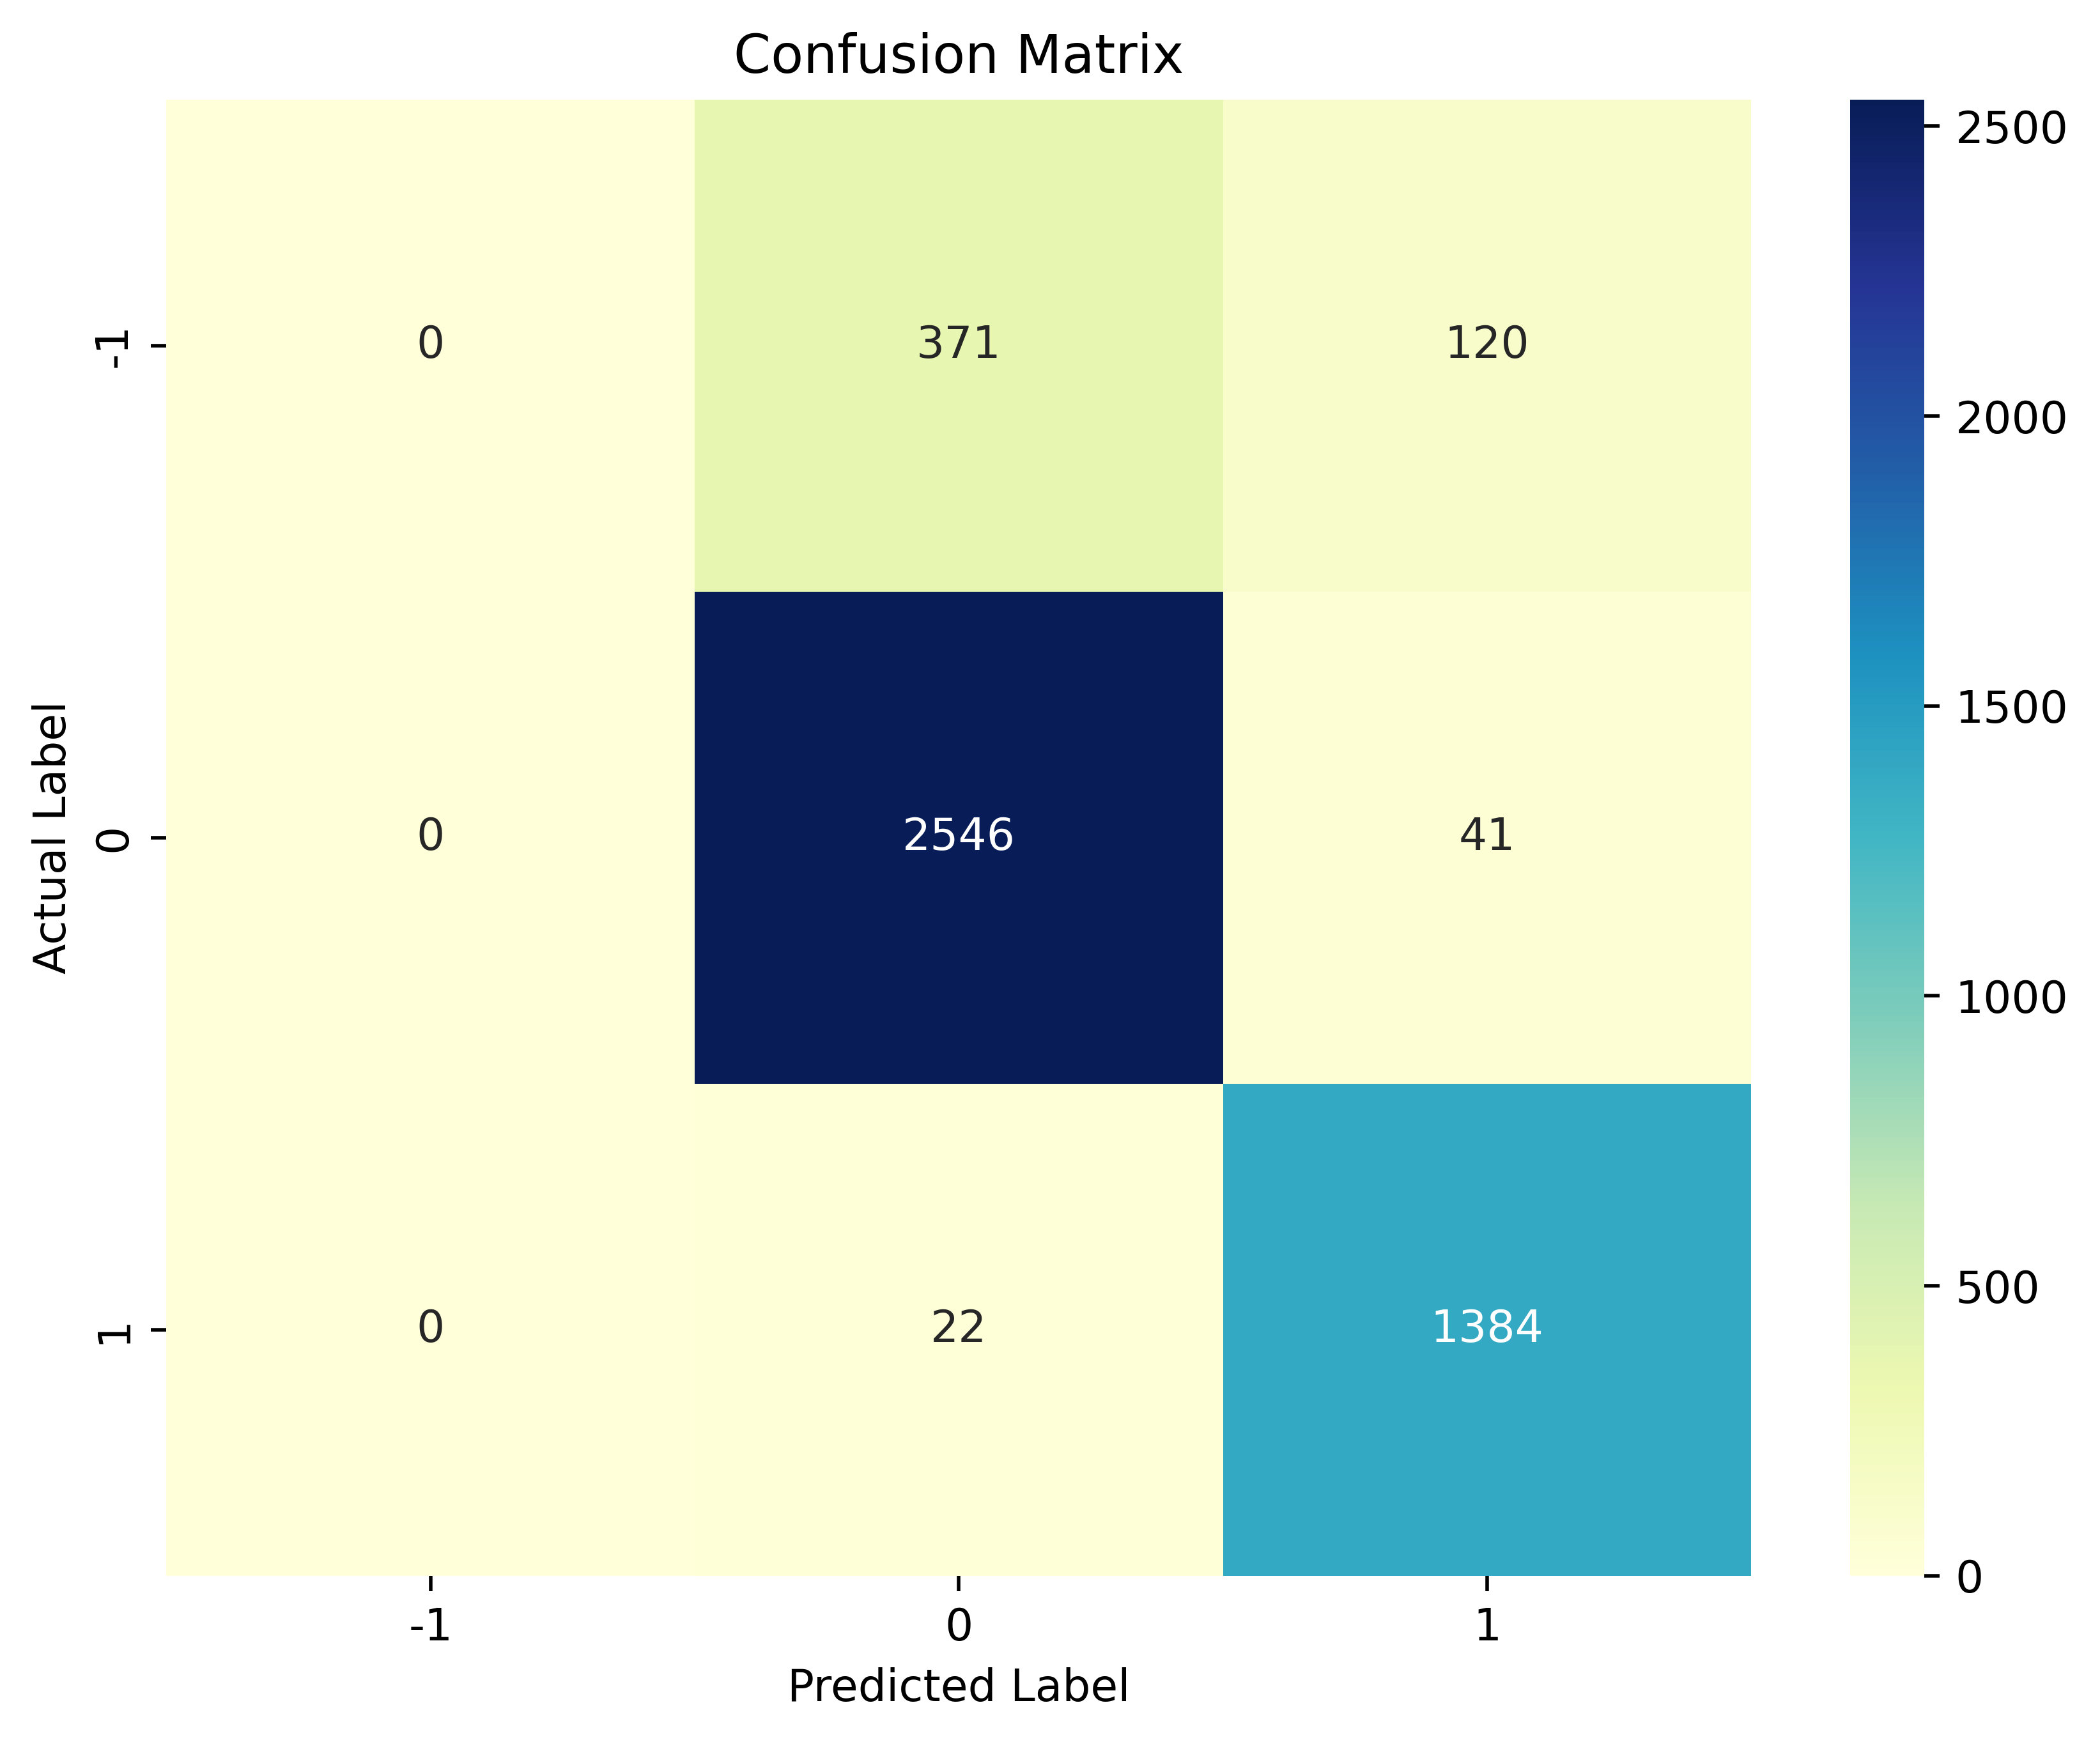

Confusion Matrix:
 [[   0  371  120]
 [   0 2546   41]
 [   0   22 1384]]


In [16]:
original_labels = [-1, 0, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, pred_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu", xticklabels=original_labels, yticklabels=original_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Display the confusion matrix
print("Confusion Matrix:\n", cm)

In [17]:
# Classification Report
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       491
           0       0.87      0.98      0.92      2587
           1       0.90      0.98      0.94      1406

    accuracy                           0.88      4484
   macro avg       0.59      0.66      0.62      4484
weighted avg       0.78      0.88      0.83      4484



/Users/josh/Desktop/Coding 👨🏽‍💻/sentiment_analysis/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/josh/Desktop/Coding 👨🏽‍💻/sentiment_analysis/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/josh/Desktop/Coding 👨🏽‍💻/sentiment_analysis/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th